## Model selection 

Librairies

In [78]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import re
import sklearn
import random
import textdistance
import umap
import pickle

from sklearn.tree              import DecisionTreeClassifier
from sklearn.model_selection   import train_test_split
from sklearn                   import metrics
from sklearn.model_selection   import GridSearchCV
from transformers              import BertTokenizer, BertModel
from sentence_transformers     import SentenceTransformer
from sklearn.metrics           import roc_curve
from umap                      import UMAP
from typing                    import Optional
from sklearn.decomposition     import PCA
from sklearn.linear_model      import LogisticRegression

Import data

In [79]:
chanel_junk_valid_new = pd.read_excel('C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel_junk_valid_2.xlsx')
ENCODER_ID = "all-MiniLM-L6-v2"
encoder = SentenceTransformer(ENCODER_ID)

X = encoder.encode(chanel_junk_valid_new['text'])
y = chanel_junk_valid_new['is_junk']

#### Selection using AUC 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarnin

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\a.tekiouk\AppDa

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: User

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are m

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line 

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:416: LineSearchWarning: Rounding errors preve

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\a.tekio

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algor

C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\a.tekiouk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


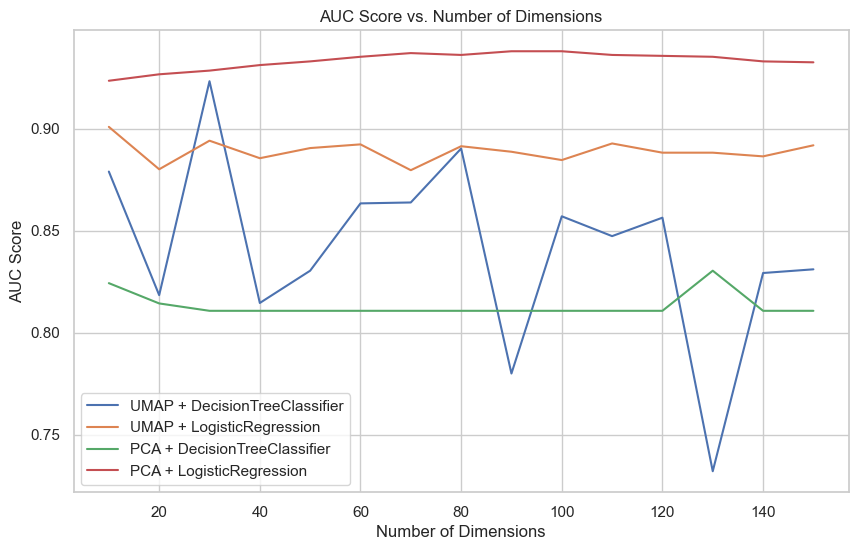

best model : LogisticRegression(max_iter=1000, random_state=42), hyperparameters = {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
AUC : 0.9380370872908187
Optimal number of dimensions : 90
Best reducing method : PCA(n_components=90)


In [77]:
best_model_auc,best_auc,opt_dim,reducer = utilities.auto_model_selection(
    X=X,
    y=y,
    dimension_range=range(10,160,10))
print(f"best model : {best_model_auc}, hyperparameters = {best_model_auc.get_params()}\nAUC : {best_auc}\nOptimal number of dimensions : {opt_dim}\nBest reducing method : {reducer}")

**model** :LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')  
**dimensions** : PCA(90)

*Serialization*

In [90]:
with open('C:/Users/a.tekiouk/Sujet_2/Sujet_2/Models/model_auc.pkl', 'wb') as f:  # open a text file
    pickle.dump(best_model_auc, f) # serialize the model
with open('C:/Users/a.tekiouk/Sujet_2/Sujet_2/Models/opt_reducer.pkl', 'wb') as f:  # open a text file
    pickle.dump(reducer, f) # serialize the reducer

#### Optimization using precision

In [3]:
# with open('C:/Users/a.tekiouk/Sujet_2/Sujet_2/Models/model_auc.pkl', 'rb') as f:
#     best_model_auc = pickle.load(f) # deserialize using load()
# with open('C:/Users/a.tekiouk/Sujet_2/Sujet_2/Models/opt_reducer.pkl', 'rb') as f:
#     reducer = pickle.load(f) # deserialize using load()

In [91]:
pre_X_train, pre_X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train = reducer.transform(pre_X_train)
X_test = reducer.transform(pre_X_test)

AUC : 0.938
Accuracy score : 0.900
Precision score : 0.926
Recall score : 0.758


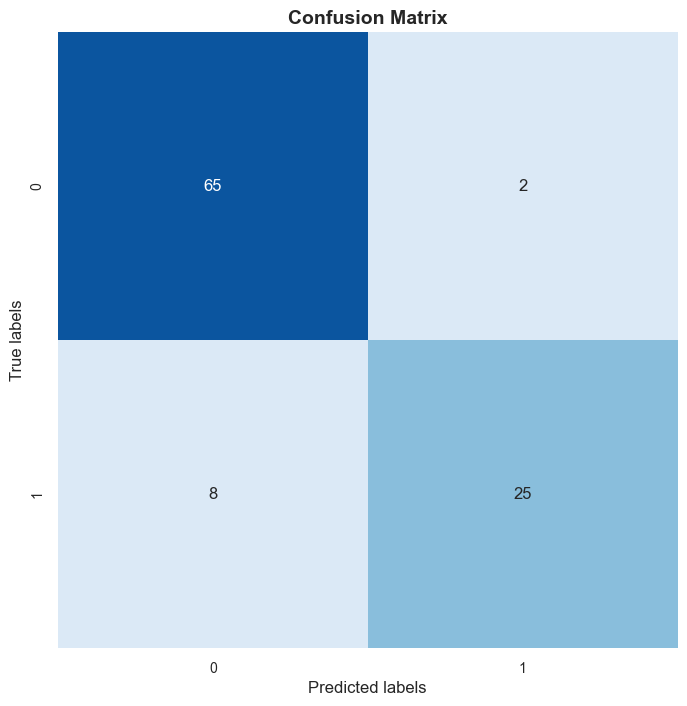

In [92]:
utilities.evaluate(y_test,best_model_auc.predict(X_test),best_model_auc.predict_proba(X_test)[:, 1])

Adapting probability threshold to classify a post as "junk"

In [7]:
threshold = 0.50
y_p2 = best_model_auc.predict(X_train)
y_score = best_model_auc.predict_proba(X_train)
print(f"Recall : {metrics.recall_score(y_train, best_model_auc.predict(X_train))}")
print(f"Precision : {metrics.precision_score(y_train, best_model_auc.predict(X_train))}")
while (metrics.recall_score(y_train, y_p2)>0.65):
    threshold = threshold+0.01
    y_p2 = np.where(y_score[:, 1] > threshold, 1, 0)

print(f"Threshold : {threshold}")
print(f"Recall : {metrics.recall_score(y_train, y_p2)}")
print(f"Precision : {metrics.precision_score(y_train, y_p2)}")
# Threshhold proba : 0.56

Recall : 0.7354838709677419
Precision : 0.9047619047619048
Threshold : 0.56
Recall : 0.632258064516129
Precision : 0.9423076923076923


AUC : 0.938
Accuracy score : 0.900
Precision score : 0.926
Recall score : 0.758


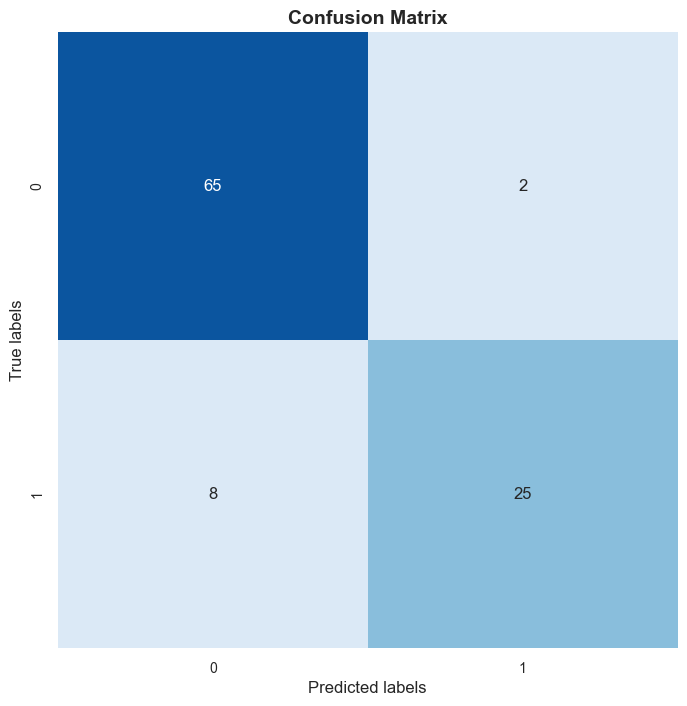

In [16]:
y_p_f = np.where(best_model_auc.predict_proba(X_test)[:, 1] > 0.5, 1, 0)
utilities.evaluate(y_test,y_p_f,best_model_auc.predict_proba(X_test)[:, 1])

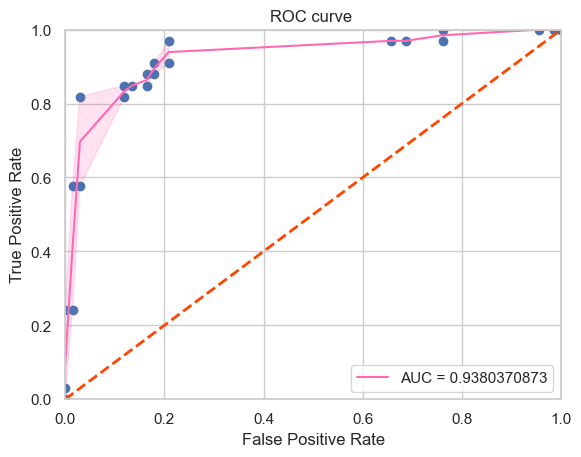

In [14]:
utilities.plot_roc(y_test,best_model_auc.predict_proba(X_test)[:, 1])

Misclassified observations

In [83]:
X_2 = pd.DataFrame(X)
X_2['id'] = chanel_junk_valid_new['id']

In [84]:
_, pre_X_test_2, _, y_test = train_test_split(X_2,y, test_size=0.2, random_state=42)

In [85]:
id_test = pre_X_test_2['id']

In [86]:
id_pred = pd.DataFrame({'id' : id_test, 'y_pred' : best_model_auc.predict(X_test)})

In [87]:
final_text_pred = pd.merge(id_pred,chanel_junk_valid_new[['text','id','is_junk']], on='id')

In [88]:
final_text_pred

,id,y_pred,text,is_junk
0,361,0,inshapeoutfits,1
1,73,1,🤍\n21系列\n\nItem number: 2482\nSize: 19x15x7cm\...,1
2,374,0,Alfie Delevingne today 💘,0
3,155,0,First lady and her son welcome a 19.5-foot b...,0
4,104,1,Leather & Denim \n\nPerf (old) \nJupe \nSola...,0
...,...,...,...,...
95,347,1,💙gros craquage sur ce jeans à Paris 💙vous aime...,1
96,86,1,Život je dar. Každé ráno vstaň a pripomeň si t...,1
97,75,1,【information】\n\nNEW YORK JOE expensiveは4月29日(...,1
98,438,0,Business attire on Tuesday 👀☀️,0


In [89]:
final_text_pred[final_text_pred['y_pred']!=final_text_pred['is_junk']][['y_pred','is_junk','text']]

,y_pred,is_junk,text
0,0,1,inshapeoutfits
4,1,0,Leather & Denim \n\nPerf (old) \nJupe \nSola...
11,0,1,Wow Our Kala Set in Pink is a Stunner 💞💫 Ladie...
21,0,1,served up look-after-look for her multi-event ...
22,0,1,Hair and makeup bellaartistryy29 \n___________...
30,0,1,diddy attended the game last night with recor...
41,1,0,🥂🎤🌪💥\n\n#뉴진스 \n 22.08.03
63,0,1,mi reina🖤
66,0,1,Jennie with Jessica from Girls’ Generation 🫶🏻\...
79,0,1,Iconic Pearl chanel 🤍\n\n📲DM to shop
